In [1]:
import pandas as pd
import glob
import time
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics

submit20190428に特徴量追加  
バリデーションの方法いろいろ試した中でLBが一番良かった。  
LBはそんなだったけど、なんか一番自信あった

In [2]:
df_train = pd.DataFrame()
train_features_path = ['../features/train__200__important_columns.pkl',
                       '../features/train__201__rolling_mean_per_FlightRegime.pkl',
                       '../features/train__202__diff_from_first_some_data.pkl',
                       '../features/train__203__agg_diff_from_first_some_data.pkl',
                       '../features/train__004__cumsum_per_FlightRegime.pkl',
                       '../features/train__005__count_FlightRegime.pkl'
                       ]
for file_path in train_features_path:
    print(file_path)
    df_tmp = pd.read_pickle(file_path)
    df_train = pd.concat([df_train, df_tmp], axis=1)

../features/train__200__important_columns.pkl
../features/train__201__rolling_mean_per_FlightRegime.pkl
../features/train__202__diff_from_first_some_data.pkl
../features/train__203__agg_diff_from_first_some_data.pkl
../features/train__004__cumsum_per_FlightRegime.pkl
../features/train__005__count_FlightRegime.pkl


In [3]:
df_test = pd.DataFrame()
test_features_path = ['../features/test__200__important_columns.pkl',
                       '../features/test__201__rolling_mean_per_FlightRegime.pkl',
                       '../features/test__202__diff_from_first_some_data.pkl',
                       '../features/test__203__agg_diff_from_first_some_data.pkl',
                       '../features/test__004__cumsum_per_FlightRegime.pkl',
                       '../features/test__005__count_FlightRegime.pkl'
                       ]
for file_path in test_features_path:
    df_tmp = pd.read_pickle(file_path)
    df_test = pd.concat([df_test, df_tmp], axis=1)

In [4]:
target = pd.read_pickle('../features/target__000__raw_data.pkl')

In [5]:
Engine_list_sort_by_length = list(df_train.EngineID.value_counts().index)
folds_EngineID = []
folds_EngineID.append(Engine_list_sort_by_length[0::10])
folds_EngineID.append(Engine_list_sort_by_length[1::10])
folds_EngineID.append(Engine_list_sort_by_length[2::10])
folds_EngineID.append(Engine_list_sort_by_length[3::10])
folds_EngineID.append(Engine_list_sort_by_length[4::10])
folds_EngineID.append(Engine_list_sort_by_length[5::10])
folds_EngineID.append(Engine_list_sort_by_length[6::10])
folds_EngineID.append(Engine_list_sort_by_length[7::10])
folds_EngineID.append(Engine_list_sort_by_length[8::10])
folds_EngineID.append(Engine_list_sort_by_length[9::10])

In [6]:
test_lastidx = df_test.groupby('EngineID').count().iloc[:, 0].values - 1
test_lastidx = list(test_lastidx)

In [7]:
train_idx = []
for i in range(10):
    print(i)
    train_lastidx = df_test.groupby('EngineID').count().iloc[:, 0].values - i
    train_idx.extend(list(train_lastidx))
    train_lastidx = df_test.groupby('EngineID').count().iloc[:, 0].values + i
    train_idx.extend(list(train_lastidx))
train_idx = set(train_idx)

0
1
2
3
4
5
6
7
8
9


In [8]:
oof = df_train[['EngineID', 'EngineIndex', 'Flight Regime']]
oof = pd.concat([oof, target[['lifespan']]], axis=1)
oof['pre_lifespan_over100'] = np.nan
oof['pre_lifespan_under100'] = np.nan
oof['pre_border'] = np.nan
oof['pre_all'] = np.nan
oof = oof[oof['EngineIndex'].isin(test_lastidx)]

In [9]:
oof.head()

,EngineID,EngineIndex,Flight Regime,lifespan,pre_lifespan_over100,pre_lifespan_under100,pre_border,pre_all
20,Train_Engine_001,20,6,128,NaN,NaN,NaN,NaN
21,Train_Engine_001,21,6,127,NaN,NaN,NaN,NaN
22,Train_Engine_001,22,6,126,NaN,NaN,NaN,NaN
30,Train_Engine_001,30,2,118,NaN,NaN,NaN,NaN
42,Train_Engine_001,42,6,106,NaN,NaN,NaN,NaN


----------- lifespan が100以上 or 100未満を学習-----------  
100以上:0, 100未満:1

In [10]:
target_border = target[['lifespan', 'EngineID', 'EngineIndex', 'Flight Regime']].copy()
target_border['target_border'] = np.nan
target_border.loc[target_border['lifespan'] >= 100, 'target_border'] = 0
target_border.loc[target_border['lifespan'] < 100, 'target_border'] = 1
del target_border['lifespan']

In [11]:
features = [c for c in df_train.columns if c not in ['Flight Regime', 'EngineID', 'EngineIndex']]
categorical_feats = []

In [12]:
param_border = {'num_leaves': 200,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 17,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 133,
         "n_jobs":-1}
num_round = 1000
predictions = np.zeros(len(df_test))
start = time.time()
feature_importance_list = []

In [13]:
predictions_border = np.zeros(len(df_test))
for fr in tqdm(np.sort(df_train['Flight Regime'].unique())):
    df_train_fr = df_train[df_train['Flight Regime'] == fr]
    df_test_fr = df_test[df_test['Flight Regime'] == fr]
    target_border_fr = target_border[target_border['Flight Regime'] == fr][['target_border', 'EngineID', 'EngineIndex']]
    feature_importance_df = pd.DataFrame()
    for fold_ in range(10):
        print("fold n°{}".format(fold_))
        val_ID = folds_EngineID[fold_]        
        trn_data = lgb.Dataset(df_train_fr[(~(df_train_fr['EngineID'].isin(val_ID))) &
                                           (df_train_fr['EngineIndex'].isin(train_idx))][features],
                               label=target_border_fr[(~(target_border_fr['EngineID'].isin(val_ID))) &
                                               (target_border_fr['EngineIndex'].isin(train_idx))]['target_border'],
                               categorical_feature=categorical_feats
                               )
        # testデータで予測するindexのみをval_dataで用いる
        # こうすることで、val_dataとtest_dataの分布が近づくことを狙っている
        val_data = lgb.Dataset(df_train_fr[(df_train_fr['EngineID'].isin(val_ID)) & 
                                           (df_train_fr['EngineIndex'].isin(test_lastidx))][features],
                               label=target_border_fr[(target_border_fr['EngineID'].isin(val_ID)) &
                                                      (target_border_fr['EngineIndex'].isin(test_lastidx))]['target_border'],
                               categorical_feature=categorical_feats
                               )
        clf = lgb.train(param_border,
                        trn_data,
                        num_round,
                        valid_sets=[trn_data, val_data],
                        verbose_eval=100,
                        early_stopping_rounds=200)
        
        val_pre =clf.predict(df_train_fr[(df_train_fr['EngineID'].isin(val_ID)) & 
                                         (df_train_fr['EngineIndex'].isin(test_lastidx))][features],
                             num_iteration=clf.best_iteration)
        
        oof.loc[(oof['Flight Regime'] == fr) &
                (oof['EngineID'].isin(val_ID)) & 
                (oof['EngineIndex'].isin(test_lastidx)), 'pre_border'] = val_pre
        
        predictions_border[df_test_fr.index] += clf.predict(df_test_fr[features], 
                                                            num_iteration=clf.best_iteration) / 10

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.939397
[200]	training's auc: 1	valid_1's auc: 0.939248
Early stopping, best iteration is:
[14]	training's auc: 0.988915	valid_1's auc: 0.943563
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.999937	valid_1's auc: 0.934497
[200]	training's auc: 1	valid_1's auc: 0.931479
Early stopping, best iteration is:
[34]	training's auc: 0.997933	valid_1's auc: 0.943855
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.95961
[200]	training's auc: 1	valid_1's auc: 0.963689
Early stopping, best iteration is:
[74]	training's auc: 1	valid_1's auc: 0.962783
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.933602
[200]	training's auc: 1	valid_1's auc: 0.93106
Early stopping, best iteration is:
[62]	training's auc: 0.999974	valid_1's auc: 0.936355
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.930874
[200]	training's auc: 1	valid_1's auc: 0.931641
Early stopping, best iteration is:
[75]	training's auc: 1	valid_1's auc: 0.934475
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.945681
[200]	training's auc: 1	valid_1's auc: 0.945822
Early stopping, best iteration is:
[46]	training's auc: 0.999473	valid_1's auc: 0.949484
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.952608
[200]	training's auc: 1	valid_1's auc: 0.954358
Early stopping, best iteration is:
[79]	training's auc: 1	valid_1's auc: 0.95388
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.951561
[200]	training's auc: 1	valid_1's auc: 0.953454
Early stopping, best iteration is:
[83]	training's auc: 1	valid_1's auc: 0.949178
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.924574
[200]	training's auc: 1	valid_1's auc: 0.924204
Early stopping, best iteration is:
[78]	training's auc: 1	valid_1's auc: 0.921559
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.925099
[200]	training's auc: 1	valid_1's auc: 0.928156
Early stopping, best iteration is:
[40]	training's auc: 0.999167	valid_1's auc: 0.931114


 17%|█████████████▊                                                                     | 1/6 [02:35<12:56, 155.29s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.999999	valid_1's auc: 0.945131
[200]	training's auc: 1	valid_1's auc: 0.945537
[300]	training's auc: 1	valid_1's auc: 0.947056
Early stopping, best iteration is:
[114]	training's auc: 0.999999	valid_1's auc: 0.94731
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.946375
[200]	training's auc: 1	valid_1's auc: 0.947001
Early stopping, best iteration is:
[75]	training's auc: 1	valid_1's auc: 0.946948
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.942843
[200]	training's auc: 1	valid_1's auc: 0.942133
Early stopping, best iteration is:
[71]	training's auc: 1	valid_1's auc: 0.943116
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.909109
[200]	training's auc: 1	valid_1's auc: 0.914581
Early stopping, best iteration is:
[73]	training's auc: 1	valid_1's auc: 0.909464
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.890864
[200]	training's auc: 1	valid_1's auc: 0.888954
Early stopping, best iteration is:
[12]	training's auc: 0.988228	valid_1's auc: 0.900607
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.920995
[200]	training's auc: 1	valid_1's auc: 0.925472
Early stopping, best iteration is:
[66]	training's auc: 1	valid_1's auc: 0.920719
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.999996	valid_1's auc: 0.933344
[200]	training's auc: 1	valid_1's auc: 0.93441
[300]	training's auc: 1	valid_1's auc: 0.937127
Early stopping, best iteration is:
[191]	training's auc: 1	valid_1's auc: 0.934516
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.93583
[200]	training's auc: 1	valid_1's auc: 0.932296
Early stopping, best iteration is:
[80]	training's auc: 1	valid_1's auc: 0.932234
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.935104
[200]	training's auc: 1	valid_1's auc: 0.93079
Early stopping, best iteration is:
[47]	training's auc: 0.999865	valid_1's auc: 0.938864
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.95664
[200]	training's auc: 1	valid_1's auc: 0.9592
Early stopping, best iteration is:
[78]	training's auc: 1	valid_1's auc: 0.955787


 33%|███████████████████████████▋                                                       | 2/6 [05:16<10:28, 157.20s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.948793
[200]	training's auc: 1	valid_1's auc: 0.950696
Early stopping, best iteration is:
[88]	training's auc: 1	valid_1's auc: 0.949717
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.948538
[200]	training's auc: 1	valid_1's auc: 0.950323
Early stopping, best iteration is:
[87]	training's auc: 1	valid_1's auc: 0.950743
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.954733
[200]	training's auc: 1	valid_1's auc: 0.955921
Early stopping, best iteration is:
[81]	training's auc: 1	valid_1's auc: 0.954281
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.93367
[200]	training's auc: 1	valid_1's auc: 0.935112
Early stopping, best iteration is:
[81]	training's auc: 1	valid_1's auc: 0.93409
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.966929
[200]	training's auc: 1	valid_1's auc: 0.965167
Early stopping, best iteration is:
[86]	training's auc: 1	valid_1's auc: 0.96734
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.903824
[200]	training's auc: 1	valid_1's auc: 0.904698
Early stopping, best iteration is:
[4]	training's auc: 0.980231	valid_1's auc: 0.91043
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.929151
[200]	training's auc: 1	valid_1's auc: 0.932368
Early stopping, best iteration is:
[83]	training's auc: 1	valid_1's auc: 0.926705
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.999994	valid_1's auc: 0.960311
[200]	training's auc: 1	valid_1's auc: 0.962598
Early stopping, best iteration is:
[23]	training's auc: 0.995293	valid_1's auc: 0.964195
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.918653
[200]	training's auc: 1	valid_1's auc: 0.921974
Early stopping, best iteration is:
[26]	training's auc: 0.996995	valid_1's auc: 0.929841
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.932495
[200]	training's auc: 1	valid_1's auc: 0.935298
Early stopping, best iteration is:
[40]	training's auc: 0.999271	valid_1's auc: 0.93573


 50%|█████████████████████████████████████████▌                                         | 3/6 [07:53<07:51, 157.11s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.954419
[200]	training's auc: 1	valid_1's auc: 0.953346
Early stopping, best iteration is:
[43]	training's auc: 0.999461	valid_1's auc: 0.958902
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.923077
[200]	training's auc: 1	valid_1's auc: 0.924858
Early stopping, best iteration is:
[77]	training's auc: 1	valid_1's auc: 0.921652
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.958942
[200]	training's auc: 1	valid_1's auc: 0.960952
Early stopping, best iteration is:
[26]	training's auc: 0.996101	valid_1's auc: 0.963651
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.953228
[200]	training's auc: 1	valid_1's auc: 0.951496
Early stopping, best iteration is:
[85]	training's auc: 1	valid_1's auc: 0.952336
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.920733
[200]	training's auc: 1	valid_1's auc: 0.918375
Early stopping, best iteration is:
[28]	training's auc: 0.996951	valid_1's auc: 0.934458
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.999987	valid_1's auc: 0.920265
[200]	training's auc: 1	valid_1's auc: 0.922159
Early stopping, best iteration is:
[89]	training's auc: 0.999986	valid_1's auc: 0.923359
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.9367
[200]	training's auc: 1	valid_1's auc: 0.93623
Early stopping, best iteration is:
[51]	training's auc: 0.999834	valid_1's auc: 0.939225
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.952196
[200]	training's auc: 1	valid_1's auc: 0.955761
Early stopping, best iteration is:
[74]	training's auc: 1	valid_1's auc: 0.951351
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.940467
[200]	training's auc: 1	valid_1's auc: 0.941868
Early stopping, best iteration is:
[24]	training's auc: 0.995718	valid_1's auc: 0.949233
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.956631
[200]	training's auc: 1	valid_1's auc: 0.961159
Early stopping, best iteration is:
[72]	training's auc: 1	valid_1's auc: 0.953807


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [10:23<05:10, 155.01s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.940178
[200]	training's auc: 1	valid_1's auc: 0.939399
Early stopping, best iteration is:
[62]	training's auc: 0.999992	valid_1's auc: 0.94428
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.940607
[200]	training's auc: 1	valid_1's auc: 0.939579
Early stopping, best iteration is:
[41]	training's auc: 0.999086	valid_1's auc: 0.950587
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.966911
[200]	training's auc: 1	valid_1's auc: 0.969597
Early stopping, best iteration is:
[22]	training's auc: 0.993657	valid_1's auc: 0.973443
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.929519
[200]	training's auc: 1	valid_1's auc: 0.928856
Early stopping, best iteration is:
[94]	training's auc: 1	valid_1's auc: 0.929464
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.96554
[200]	training's auc: 1	valid_1's auc: 0.965931
Early stopping, best iteration is:
[64]	training's auc: 0.999983	valid_1's auc: 0.96795
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.899034
[200]	training's auc: 1	valid_1's auc: 0.900308
Early stopping, best iteration is:
[73]	training's auc: 1	valid_1's auc: 0.901687
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.923254
[200]	training's auc: 1	valid_1's auc: 0.928817
Early stopping, best iteration is:
[11]	training's auc: 0.987212	valid_1's auc: 0.935089
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.926054
[200]	training's auc: 1	valid_1's auc: 0.926884
Early stopping, best iteration is:
[76]	training's auc: 1	valid_1's auc: 0.92567
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.956612
[200]	training's auc: 1	valid_1's auc: 0.954728
Early stopping, best iteration is:
[45]	training's auc: 0.999574	valid_1's auc: 0.960683
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.944858
[200]	training's auc: 1	valid_1's auc: 0.945333
Early stopping, best iteration is:
[73]	training's auc: 1	valid_1's auc: 0.942623


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [13:01<02:35, 155.69s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.962172
[200]	training's auc: 1	valid_1's auc: 0.960404
Early stopping, best iteration is:
[74]	training's auc: 1	valid_1's auc: 0.962129
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.919253
[200]	training's auc: 1	valid_1's auc: 0.920354
Early stopping, best iteration is:
[15]	training's auc: 0.993235	valid_1's auc: 0.924249
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.954282
[200]	training's auc: 1	valid_1's auc: 0.953111
Early stopping, best iteration is:
[61]	training's auc: 0.999999	valid_1's auc: 0.95672
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.932478
[200]	training's auc: 1	valid_1's auc: 0.939113
Early stopping, best iteration is:
[73]	training's auc: 1	valid_1's auc: 0.930252
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.999995	valid_1's auc: 0.942212
[200]	training's auc: 0.999999	valid_1's auc: 0.941244
Early stopping, best iteration is:
[46]	training's auc: 0.999872	valid_1's auc: 0.950541
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.925343
[200]	training's auc: 1	valid_1's auc: 0.922962
Early stopping, best iteration is:
[70]	training's auc: 1	valid_1's auc: 0.925467
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.947926
[200]	training's auc: 1	valid_1's auc: 0.949188
Early stopping, best iteration is:
[66]	training's auc: 1	valid_1's auc: 0.946897
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.946116
[200]	training's auc: 1	valid_1's auc: 0.946789
Early stopping, best iteration is:
[71]	training's auc: 1	valid_1's auc: 0.943405
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.902285
[200]	training's auc: 1	valid_1's auc: 0.906268
Early stopping, best iteration is:
[26]	training's auc: 0.998067	valid_1's auc: 0.90924
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 1	valid_1's auc: 0.943637
[200]	training's auc: 1	valid_1's auc: 0.941635
Early stopping, best iteration is:
[21]	training's auc: 0.996399	valid_1's auc: 0.946364


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [16:45<00:00, 176.24s/it]


In [14]:
test_pre_border = predictions_border

In [15]:
oof['target_border'] = 0
oof.loc[oof['lifespan'] >= 100, 'target_border'] = 0
oof.loc[oof['lifespan'] < 100, 'target_border'] = 1

In [16]:
# f: 004, 005, 200, 201, 202, 203
fpr, tpr, thresholds = metrics.roc_curve(oof.dropna(subset=['pre_border'])['target_border'],
                                         oof.dropna(subset=['pre_border'])['pre_border'])
metrics.auc(fpr, tpr)

0.9336692607529476

In [18]:
for i in np.sort(oof['Flight Regime'].unique()):
    oof_1fr = oof[oof['Flight Regime'] == i].dropna(subset=['pre_border'])
    fpr, tpr, thresholds = metrics.roc_curve(oof_1fr['target_border'], oof_1fr['pre_border'])
    print('Flight Regime', i , ':', metrics.auc(fpr, tpr))

Flight Regime 1 : 0.9366000029547024
Flight Regime 2 : 0.9279637585371228
Flight Regime 3 : 0.931893503499742
Flight Regime 4 : 0.939491605854932
Flight Regime 5 : 0.9333662380335314
Flight Regime 6 : 0.9345014857463558


In [23]:
mean_absolute_error(oof['target_border'], oof['pre_border'])

0.18570274415874916

C:\Users\linda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


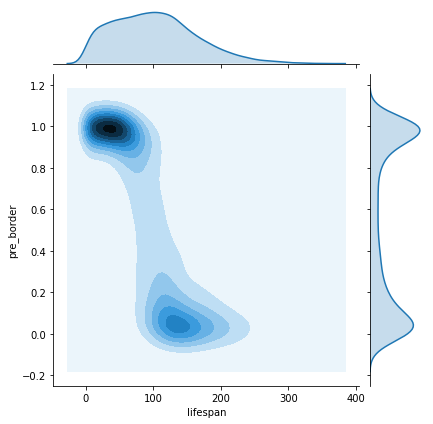

In [22]:
sns.jointplot(x="lifespan", y="pre_border", kind="kde", data=oof.dropna(subset=['pre_border']));

まあまあいい感じに見える？

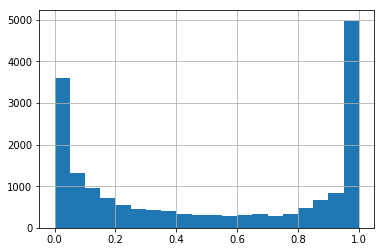

In [24]:
oof['pre_border'].hist(bins=20)

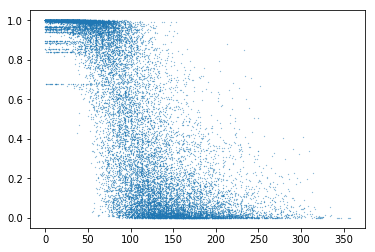

In [26]:
plt.plot(oof['lifespan'], oof['pre_border'], 'o', markersize=0.2)

=================  target < 100 のみ学習 ===============

In [27]:
df_train_under = pd.concat([df_train, target['lifespan']], axis=1)
df_train_under = df_train_under[df_train_under['lifespan'] < 100]

target_under = target[target['lifespan'] < 100]
target_under_max = target_under['lifespan'].max()
target_under['lifespan'] = target_under['lifespan'] / target_under_max
del df_train_under['lifespan']

C:\Users\linda\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149,
         'objective': 'xentropy',
         'max_depth': 9,
         'learning_rate': 0.050,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083,
         "bagging_seed": 11,
         "metric": 'mae',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [29]:
predictions_under = np.zeros(len(df_test))
for fr in tqdm(np.sort(df_train['Flight Regime'].unique())):
    df_train_fr = df_train_under[df_train_under['Flight Regime'] == fr]
    df_test_fr = df_test[df_test['Flight Regime'] == fr]
    target_fr = target_under[target_under['Flight Regime'] == fr][['lifespan', 'EngineID', 'EngineIndex']]
    feature_importance_df = pd.DataFrame()
    for fold_ in range(10):
        print("fold n°{}".format(fold_))
        val_ID = folds_EngineID[fold_]        
        trn_data = lgb.Dataset(df_train_fr[(~(df_train_fr['EngineID'].isin(val_ID))) &
                                           (df_train_fr['EngineIndex'].isin(train_idx))][features],
                               label=target_fr[(~(target_fr['EngineID'].isin(val_ID))) &
                                               (target_fr['EngineIndex'].isin(train_idx))]['lifespan'],
                               categorical_feature=categorical_feats
                               )
        # testデータで予測するindexのみをval_dataで用いる
        # こうすることで、val_dataとtest_dataの分布が近づくことを狙っている
        val_data = lgb.Dataset(df_train_fr[(df_train_fr['EngineID'].isin(val_ID)) & 
                                           (df_train_fr['EngineIndex'].isin(test_lastidx))][features],
                               label=target_fr[target_fr['EngineID'].isin(val_ID) &
                                               target_fr['EngineIndex'].isin(test_lastidx)]['lifespan'],
                               categorical_feature=categorical_feats
                               )
        clf = lgb.train(param,
                        trn_data,
                        num_round,
                        valid_sets=[trn_data, val_data],
                        verbose_eval=100,
                        early_stopping_rounds=200)
        
        val_pre =clf.predict(df_train[(df_train['Flight Regime'] == fr)&
                                      (df_train['EngineID'].isin(val_ID)) & 
                                      (df_train['EngineIndex'].isin(test_lastidx))][features],
                             num_iteration=clf.best_iteration)
        
        oof.loc[(oof['Flight Regime'] == fr) &
                (oof['EngineID'].isin(val_ID)) & 
                (oof['EngineIndex'].isin(test_lastidx)), 'pre_lifespan_under100'] = val_pre
        
        predictions_under[df_test_fr.index] += clf.predict(df_test_fr[features], num_iteration=clf.best_iteration) / 10

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0611048	valid_1's l1: 0.0777624
[200]	training's l1: 0.0474855	valid_1's l1: 0.0773911
[300]	training's l1: 0.0400664	valid_1's l1: 0.0781129
Early stopping, best iteration is:
[156]	training's l1: 0.0521233	valid_1's l1: 0.0767616
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0604865	valid_1's l1: 0.0747703
[200]	training's l1: 0.0475261	valid_1's l1: 0.0720216
[300]	training's l1: 0.0400041	valid_1's l1: 0.0722141
Early stopping, best iteration is:
[176]	training's l1: 0.049808	valid_1's l1: 0.0716314
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0607552	valid_1's l1: 0.0699534
[200]	training's l1: 0.0474895	valid_1's l1: 0.0646304
[300]	training's l1: 0.0399949	valid_1's l1: 0.0628928
[400]	training's l1: 0.0348524	valid_1's l1: 0.0615913
[500]	training's l1: 0.0309336	valid_1's l1: 0.0613071
[600]	training's l1: 0.0277771	valid_1's l1: 0.0610377
[700]	training's l1: 0.0253546	valid_1's l1: 0.0606531
[800]	training's l1: 0.0233315	valid_1's l1: 0.0603387
[900]	training's l1: 0.0215664	valid_1's l1: 0.0604432
[1000]	training's l1: 0.0201396	valid_1's l1: 0.0600857
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.0201396	valid_1's l1: 0.0600857
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0593014	valid_1's l1: 0.101742
[200]	training's l1: 0.0462483	valid_1's l1: 0.0978328
[300]	training's l1: 0.0388661	valid_1's l1: 0.0972702
[400]	training's l1: 0.0336914	valid_1's l1: 0.0973056
[500]	training's l1: 0.030012	valid_1's l1: 0.0970574
[600]	training's l1: 0.0270137	valid_1's l1: 0.0972123
Early stopping, best iteration is:
[460]	training's l1: 0.0314504	valid_1's l1: 0.0965872
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0595727	valid_1's l1: 0.0763179
[200]	training's l1: 0.0465157	valid_1's l1: 0.0770683
Early stopping, best iteration is:
[88]	training's l1: 0.0622838	valid_1's l1: 0.0758252
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.059559	valid_1's l1: 0.0855289
[200]	training's l1: 0.0469527	valid_1's l1: 0.0851931
[300]	training's l1: 0.0396387	valid_1's l1: 0.0841271
[400]	training's l1: 0.034451	valid_1's l1: 0.0845937
Early stopping, best iteration is:
[256]	training's l1: 0.0425969	valid_1's l1: 0.0835641
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0602453	valid_1's l1: 0.080025
[200]	training's l1: 0.0468462	valid_1's l1: 0.0760077
[300]	training's l1: 0.0395014	valid_1's l1: 0.0741038
[400]	training's l1: 0.034179	valid_1's l1: 0.0741612
[500]	training's l1: 0.0302727	valid_1's l1: 0.0743438
[600]	training's l1: 0.0272605	valid_1's l1: 0.0742002
[700]	training's l1: 0.0248292	valid_1's l1: 0.0743693
Early stopping, best iteration is:
[554]	training's l1: 0.0285468	valid_1's l1: 0.0738183
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0604434	valid_1's l1: 0.0835232
[200]	training's l1: 0.0473117	valid_1's l1: 0.0825356
[300]	training's l1: 0.0399169	valid_1's l1: 0.0830604
Early stopping, best iteration is:
[192]	training's l1: 0.04812	valid_1's l1: 0.0821315
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0602477	valid_1's l1: 0.0756935
[200]	training's l1: 0.0468544	valid_1's l1: 0.07504
[300]	training's l1: 0.0394039	valid_1's l1: 0.0760975
Early stopping, best iteration is:
[160]	training's l1: 0.0512255	valid_1's l1: 0.0747492
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0601189	valid_1's l1: 0.0913121
[200]	training's l1: 0.0467424	valid_1's l1: 0.0891515
[300]	training's l1: 0.0393005	valid_1's l1: 0.0884543
[400]	training's l1: 0.0341485	valid_1's l1: 0.0887344
[500]	training's l1: 0.030249	valid_1's l1: 0.0889847
Early stopping, best iteration is:
[310]	training's l1: 0.0386571	valid_1's l1: 0.0883321


 17%|██████████████                                                                      | 1/6 [01:34<07:50, 94.05s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0601601	valid_1's l1: 0.0665438
[200]	training's l1: 0.0463871	valid_1's l1: 0.0654449
[300]	training's l1: 0.0389757	valid_1's l1: 0.0663825
Early stopping, best iteration is:
[153]	training's l1: 0.0511815	valid_1's l1: 0.0647649
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0601521	valid_1's l1: 0.0795437
[200]	training's l1: 0.046391	valid_1's l1: 0.0764252
[300]	training's l1: 0.0393094	valid_1's l1: 0.0763876
[400]	training's l1: 0.034381	valid_1's l1: 0.0766192
[500]	training's l1: 0.0305602	valid_1's l1: 0.0771583
Early stopping, best iteration is:
[329]	training's l1: 0.0377197	valid_1's l1: 0.0761799
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0605074	valid_1's l1: 0.0783636
[200]	training's l1: 0.0468001	valid_1's l1: 0.0747763
[300]	training's l1: 0.0392663	valid_1's l1: 0.0757496
Early stopping, best iteration is:
[195]	training's l1: 0.0472971	valid_1's l1: 0.0747106
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.060058	valid_1's l1: 0.0853957
[200]	training's l1: 0.0464001	valid_1's l1: 0.0825026
[300]	training's l1: 0.0392195	valid_1's l1: 0.0824817
[400]	training's l1: 0.0339638	valid_1's l1: 0.0819352
[500]	training's l1: 0.0302471	valid_1's l1: 0.0822312
[600]	training's l1: 0.0273184	valid_1's l1: 0.0825254
Early stopping, best iteration is:
[407]	training's l1: 0.0336783	valid_1's l1: 0.0817409
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0592406	valid_1's l1: 0.0837686
[200]	training's l1: 0.0452346	valid_1's l1: 0.0825439
[300]	training's l1: 0.0378661	valid_1's l1: 0.0829609
Early stopping, best iteration is:
[158]	training's l1: 0.0497586	valid_1's l1: 0.0816476
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0593907	valid_1's l1: 0.0817639
[200]	training's l1: 0.0459387	valid_1's l1: 0.0788348
[300]	training's l1: 0.038934	valid_1's l1: 0.0781108
[400]	training's l1: 0.0339088	valid_1's l1: 0.0780292
[500]	training's l1: 0.0302565	valid_1's l1: 0.0775253
[600]	training's l1: 0.0272444	valid_1's l1: 0.0772166
[700]	training's l1: 0.024826	valid_1's l1: 0.0775523
Early stopping, best iteration is:
[594]	training's l1: 0.0274124	valid_1's l1: 0.0771547
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0604167	valid_1's l1: 0.0874252
[200]	training's l1: 0.0468299	valid_1's l1: 0.0835011
[300]	training's l1: 0.0394883	valid_1's l1: 0.083161
[400]	training's l1: 0.0343841	valid_1's l1: 0.0835652
[500]	training's l1: 0.0305597	valid_1's l1: 0.0839616
Early stopping, best iteration is:
[344]	training's l1: 0.0370845	valid_1's l1: 0.0828248
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0602594	valid_1's l1: 0.0713499
[200]	training's l1: 0.0469306	valid_1's l1: 0.0700401
[300]	training's l1: 0.0397784	valid_1's l1: 0.0696886
[400]	training's l1: 0.0345303	valid_1's l1: 0.070152
Early stopping, best iteration is:
[292]	training's l1: 0.0402108	valid_1's l1: 0.0694417
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0595688	valid_1's l1: 0.0771054
[200]	training's l1: 0.0458005	valid_1's l1: 0.0791505
Early stopping, best iteration is:
[84]	training's l1: 0.0637884	valid_1's l1: 0.076269
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0602895	valid_1's l1: 0.0828375
[200]	training's l1: 0.046625	valid_1's l1: 0.0815247
[300]	training's l1: 0.0392896	valid_1's l1: 0.0822227
Early stopping, best iteration is:
[184]	training's l1: 0.0481625	valid_1's l1: 0.0809924


 33%|████████████████████████████                                                        | 2/6 [03:00<06:06, 91.62s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0601138	valid_1's l1: 0.0679545
[200]	training's l1: 0.0464937	valid_1's l1: 0.0669276
[300]	training's l1: 0.0389216	valid_1's l1: 0.0670232
[400]	training's l1: 0.0340338	valid_1's l1: 0.0673707
Early stopping, best iteration is:
[255]	training's l1: 0.0419472	valid_1's l1: 0.0663985
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0599782	valid_1's l1: 0.0686979
[200]	training's l1: 0.0463748	valid_1's l1: 0.0661165
[300]	training's l1: 0.0388569	valid_1's l1: 0.0670445
[400]	training's l1: 0.0336963	valid_1's l1: 0.068092
Early stopping, best iteration is:
[203]	training's l1: 0.0460458	valid_1's l1: 0.0660284
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0601326	valid_1's l1: 0.0762237
[200]	training's l1: 0.0465264	valid_1's l1: 0.0727845
[300]	training's l1: 0.0390328	valid_1's l1: 0.0704021
[400]	training's l1: 0.033818	valid_1's l1: 0.0700356
[500]	training's l1: 0.0300175	valid_1's l1: 0.0711608
Early stopping, best iteration is:
[392]	training's l1: 0.034208	valid_1's l1: 0.0699228
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0588672	valid_1's l1: 0.0917584
[200]	training's l1: 0.0458815	valid_1's l1: 0.0921492
[300]	training's l1: 0.0385198	valid_1's l1: 0.0916511
[400]	training's l1: 0.0336437	valid_1's l1: 0.0916096
Early stopping, best iteration is:
[263]	training's l1: 0.0408717	valid_1's l1: 0.0910015
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0594896	valid_1's l1: 0.0770866
[200]	training's l1: 0.0458391	valid_1's l1: 0.0778494
Early stopping, best iteration is:
[84]	training's l1: 0.0635817	valid_1's l1: 0.0763496
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0586366	valid_1's l1: 0.0929785
[200]	training's l1: 0.0456146	valid_1's l1: 0.0901576
[300]	training's l1: 0.0384653	valid_1's l1: 0.0895384
[400]	training's l1: 0.0333704	valid_1's l1: 0.0908959
Early stopping, best iteration is:
[275]	training's l1: 0.0399624	valid_1's l1: 0.0893386
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0595635	valid_1's l1: 0.0774867
[200]	training's l1: 0.0456834	valid_1's l1: 0.0731899
[300]	training's l1: 0.0385562	valid_1's l1: 0.0721445
[400]	training's l1: 0.0335376	valid_1's l1: 0.0721848
[500]	training's l1: 0.0297672	valid_1's l1: 0.0717438
[600]	training's l1: 0.0268128	valid_1's l1: 0.071279
[700]	training's l1: 0.0243795	valid_1's l1: 0.0709833
[800]	training's l1: 0.0223313	valid_1's l1: 0.0710418
[900]	training's l1: 0.0206321	valid_1's l1: 0.0709752
[1000]	training's l1: 0.0192949	valid_1's l1: 0.070711
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.0192949	valid_1's l1: 0.070711
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0602611	valid_1's l1: 0.080673
[200]	training's l1: 0.0469701	valid_1's l1: 0.0753795
[300]	training's l1: 0.0393835	valid_1's l1: 0.0738937
[400]	training's l1: 0.0342813	valid_1's l1: 0.0736773
[500]	training's l1: 0.0303912	valid_1's l1: 0.0730402
[600]	training's l1: 0.027355	valid_1's l1: 0.0725118
[700]	training's l1: 0.0249015	valid_1's l1: 0.072139
[800]	training's l1: 0.0228175	valid_1's l1: 0.0716886
[900]	training's l1: 0.0211413	valid_1's l1: 0.0713632
[1000]	training's l1: 0.0196608	valid_1's l1: 0.0709955
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.0196608	valid_1's l1: 0.0709955
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0589846	valid_1's l1: 0.0875204
[200]	training's l1: 0.0460168	valid_1's l1: 0.0843411
[300]	training's l1: 0.0387268	valid_1's l1: 0.084057
[400]	training's l1: 0.033827	valid_1's l1: 0.0846049
Early stopping, best iteration is:
[216]	training's l1: 0.0446553	valid_1's l1: 0.0838334
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0601777	valid_1's l1: 0.0767484
[200]	training's l1: 0.0461837	valid_1's l1: 0.0753311
[300]	training's l1: 0.0389585	valid_1's l1: 0.0743841
[400]	training's l1: 0.0337634	valid_1's l1: 0.0741976
[500]	training's l1: 0.0300945	valid_1's l1: 0.0741806
[600]	training's l1: 0.0271135	valid_1's l1: 0.0740492
Early stopping, best iteration is:
[432]	training's l1: 0.0324991	valid_1's l1: 0.0737808


 50%|██████████████████████████████████████████                                          | 3/6 [04:43<04:45, 95.13s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0604769	valid_1's l1: 0.0883875
[200]	training's l1: 0.0462194	valid_1's l1: 0.0873451
[300]	training's l1: 0.0390339	valid_1's l1: 0.0868831
[400]	training's l1: 0.0338879	valid_1's l1: 0.0873474
Early stopping, best iteration is:
[266]	training's l1: 0.0410849	valid_1's l1: 0.0865527
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0613692	valid_1's l1: 0.0783186
[200]	training's l1: 0.0472911	valid_1's l1: 0.0778568
[300]	training's l1: 0.0395413	valid_1's l1: 0.0799193
Early stopping, best iteration is:
[135]	training's l1: 0.055132	valid_1's l1: 0.077535
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.060372	valid_1's l1: 0.0801793
[200]	training's l1: 0.0466832	valid_1's l1: 0.0784916
[300]	training's l1: 0.0389491	valid_1's l1: 0.0779956
[400]	training's l1: 0.0336928	valid_1's l1: 0.0779048
[500]	training's l1: 0.0297796	valid_1's l1: 0.0780114
[600]	training's l1: 0.0267331	valid_1's l1: 0.0784215
Early stopping, best iteration is:
[410]	training's l1: 0.0332926	valid_1's l1: 0.0777147
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0601199	valid_1's l1: 0.0919618
[200]	training's l1: 0.0460186	valid_1's l1: 0.0899192
[300]	training's l1: 0.0382298	valid_1's l1: 0.0911085
Early stopping, best iteration is:
[185]	training's l1: 0.0475827	valid_1's l1: 0.0895959
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0604482	valid_1's l1: 0.0839945
[200]	training's l1: 0.0461468	valid_1's l1: 0.084331
[300]	training's l1: 0.0385593	valid_1's l1: 0.0853544
Early stopping, best iteration is:
[161]	training's l1: 0.050682	valid_1's l1: 0.0834337
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0601914	valid_1's l1: 0.0902133
[200]	training's l1: 0.0464926	valid_1's l1: 0.0882004
[300]	training's l1: 0.0388788	valid_1's l1: 0.087248
[400]	training's l1: 0.0337613	valid_1's l1: 0.0873717
Early stopping, best iteration is:
[283]	training's l1: 0.0399271	valid_1's l1: 0.0869771
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0617973	valid_1's l1: 0.0846681
[200]	training's l1: 0.047666	valid_1's l1: 0.0832738
[300]	training's l1: 0.0401592	valid_1's l1: 0.0823785
[400]	training's l1: 0.0346537	valid_1's l1: 0.0815479
[500]	training's l1: 0.0306149	valid_1's l1: 0.0818188
Early stopping, best iteration is:
[396]	training's l1: 0.0348427	valid_1's l1: 0.0813298
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0612012	valid_1's l1: 0.0880615
[200]	training's l1: 0.0469007	valid_1's l1: 0.0834969
[300]	training's l1: 0.0393172	valid_1's l1: 0.0827649
[400]	training's l1: 0.0341524	valid_1's l1: 0.0819738
[500]	training's l1: 0.0303511	valid_1's l1: 0.0812601
[600]	training's l1: 0.0273183	valid_1's l1: 0.0812442
[700]	training's l1: 0.0248768	valid_1's l1: 0.080769
[800]	training's l1: 0.0228342	valid_1's l1: 0.080671
[900]	training's l1: 0.0211076	valid_1's l1: 0.0809001
[1000]	training's l1: 0.0196559	valid_1's l1: 0.0810494
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.0196559	valid_1's l1: 0.0810494
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0609653	valid_1's l1: 0.0712607
[200]	training's l1: 0.0471687	valid_1's l1: 0.0688153
[300]	training's l1: 0.0393591	valid_1's l1: 0.0687359
[400]	training's l1: 0.0339506	valid_1's l1: 0.0689867
Early stopping, best iteration is:
[242]	training's l1: 0.0435015	valid_1's l1: 0.0675513
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0609971	valid_1's l1: 0.0789349
[200]	training's l1: 0.0466	valid_1's l1: 0.0756749
[300]	training's l1: 0.0388701	valid_1's l1: 0.0761898
Early stopping, best iteration is:
[198]	training's l1: 0.046796	valid_1's l1: 0.0756131


 67%|████████████████████████████████████████████████████████                            | 4/6 [06:17<03:09, 94.88s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0618907	valid_1's l1: 0.066983
[200]	training's l1: 0.047155	valid_1's l1: 0.0653675
[300]	training's l1: 0.0391112	valid_1's l1: 0.0658021
Early stopping, best iteration is:
[172]	training's l1: 0.0502274	valid_1's l1: 0.0647272
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0605888	valid_1's l1: 0.0825845
[200]	training's l1: 0.046631	valid_1's l1: 0.0775344
[300]	training's l1: 0.0389534	valid_1's l1: 0.0768906
[400]	training's l1: 0.0337397	valid_1's l1: 0.0765223
[500]	training's l1: 0.0298385	valid_1's l1: 0.0756939
[600]	training's l1: 0.0267955	valid_1's l1: 0.0748904
[700]	training's l1: 0.0243602	valid_1's l1: 0.0753642
[800]	training's l1: 0.0223143	valid_1's l1: 0.075685
Early stopping, best iteration is:
[603]	training's l1: 0.0267114	valid_1's l1: 0.0747756
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0610121	valid_1's l1: 0.0775264
[200]	training's l1: 0.0463819	valid_1's l1: 0.0743936
[300]	training's l1: 0.0383634	valid_1's l1: 0.0735265
[400]	training's l1: 0.0331635	valid_1's l1: 0.0731056
[500]	training's l1: 0.0292318	valid_1's l1: 0.0724954
[600]	training's l1: 0.0262296	valid_1's l1: 0.0728415
[700]	training's l1: 0.0238239	valid_1's l1: 0.0734398
Early stopping, best iteration is:
[517]	training's l1: 0.0286577	valid_1's l1: 0.0721155
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0591455	valid_1's l1: 0.0990201
[200]	training's l1: 0.0454037	valid_1's l1: 0.100202
Early stopping, best iteration is:
[90]	training's l1: 0.0616783	valid_1's l1: 0.0983317
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0603028	valid_1's l1: 0.0857277
[200]	training's l1: 0.0463535	valid_1's l1: 0.0865255
Early stopping, best iteration is:
[84]	training's l1: 0.0645125	valid_1's l1: 0.0852576
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0598647	valid_1's l1: 0.092231
[200]	training's l1: 0.0458732	valid_1's l1: 0.0912896
[300]	training's l1: 0.0385738	valid_1's l1: 0.0896595
[400]	training's l1: 0.0334594	valid_1's l1: 0.0903125
Early stopping, best iteration is:
[296]	training's l1: 0.0388482	valid_1's l1: 0.0896031
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0606172	valid_1's l1: 0.0877261
[200]	training's l1: 0.0462931	valid_1's l1: 0.0846628
[300]	training's l1: 0.0385831	valid_1's l1: 0.0822187
[400]	training's l1: 0.0332038	valid_1's l1: 0.0816418
[500]	training's l1: 0.0292331	valid_1's l1: 0.0816977
Early stopping, best iteration is:
[362]	training's l1: 0.0349909	valid_1's l1: 0.0812692
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0603633	valid_1's l1: 0.0843973
[200]	training's l1: 0.0462295	valid_1's l1: 0.0816169
[300]	training's l1: 0.038774	valid_1's l1: 0.0814566
[400]	training's l1: 0.0332853	valid_1's l1: 0.080826
[500]	training's l1: 0.0295192	valid_1's l1: 0.0806054
[600]	training's l1: 0.0262961	valid_1's l1: 0.0803514
[700]	training's l1: 0.0238433	valid_1's l1: 0.0807289
Early stopping, best iteration is:
[579]	training's l1: 0.0269367	valid_1's l1: 0.0801995
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.060114	valid_1's l1: 0.0840664
[200]	training's l1: 0.0460065	valid_1's l1: 0.0804796
[300]	training's l1: 0.0382301	valid_1's l1: 0.0803506
[400]	training's l1: 0.0329941	valid_1's l1: 0.0800619
[500]	training's l1: 0.0290307	valid_1's l1: 0.0802701
[600]	training's l1: 0.026067	valid_1's l1: 0.0808721
Early stopping, best iteration is:
[426]	training's l1: 0.0318406	valid_1's l1: 0.079705
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0616021	valid_1's l1: 0.0689499
[200]	training's l1: 0.0467884	valid_1's l1: 0.066754
[300]	training's l1: 0.0389298	valid_1's l1: 0.0663322
[400]	training's l1: 0.0335764	valid_1's l1: 0.0652132
[500]	training's l1: 0.0297751	valid_1's l1: 0.0648263
[600]	training's l1: 0.0267542	valid_1's l1: 0.0653284
Early stopping, best iteration is:
[462]	training's l1: 0.0310561	valid_1's l1: 0.0647097


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [07:56<01:36, 96.11s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0538629	valid_1's l1: 0.0728949
[200]	training's l1: 0.0409794	valid_1's l1: 0.071607
[300]	training's l1: 0.0336469	valid_1's l1: 0.0717887
Early stopping, best iteration is:
[172]	training's l1: 0.0435135	valid_1's l1: 0.0713374
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0537498	valid_1's l1: 0.072757
[200]	training's l1: 0.0404878	valid_1's l1: 0.0707626
[300]	training's l1: 0.0333683	valid_1's l1: 0.070571
[400]	training's l1: 0.0287074	valid_1's l1: 0.0695999
[500]	training's l1: 0.0252291	valid_1's l1: 0.0696723
[600]	training's l1: 0.022503	valid_1's l1: 0.070016
Early stopping, best iteration is:
[448]	training's l1: 0.0268789	valid_1's l1: 0.0693671
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0539853	valid_1's l1: 0.0777143
[200]	training's l1: 0.0410874	valid_1's l1: 0.075933
[300]	training's l1: 0.0339534	valid_1's l1: 0.0761876
[400]	training's l1: 0.0289888	valid_1's l1: 0.0764567
Early stopping, best iteration is:
[205]	training's l1: 0.0406085	valid_1's l1: 0.0758676
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0533153	valid_1's l1: 0.095053
[200]	training's l1: 0.0405065	valid_1's l1: 0.095849
[300]	training's l1: 0.0333583	valid_1's l1: 0.0956294
Early stopping, best iteration is:
[159]	training's l1: 0.0447425	valid_1's l1: 0.0947284
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0537973	valid_1's l1: 0.0771396
[200]	training's l1: 0.0405838	valid_1's l1: 0.0750577
[300]	training's l1: 0.0332956	valid_1's l1: 0.0747306
[400]	training's l1: 0.0285963	valid_1's l1: 0.07414
[500]	training's l1: 0.0252328	valid_1's l1: 0.0748015
Early stopping, best iteration is:
[336]	training's l1: 0.0312315	valid_1's l1: 0.0739338
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0528889	valid_1's l1: 0.0842533
[200]	training's l1: 0.0402992	valid_1's l1: 0.0838119
[300]	training's l1: 0.0330949	valid_1's l1: 0.0843037
Early stopping, best iteration is:
[156]	training's l1: 0.0446359	valid_1's l1: 0.0832392
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0535557	valid_1's l1: 0.084433
[200]	training's l1: 0.0403978	valid_1's l1: 0.0810212
[300]	training's l1: 0.0331895	valid_1's l1: 0.0800819
[400]	training's l1: 0.0283731	valid_1's l1: 0.0797224
[500]	training's l1: 0.0249608	valid_1's l1: 0.078986
[600]	training's l1: 0.0222694	valid_1's l1: 0.0786641
[700]	training's l1: 0.0202119	valid_1's l1: 0.0785323
[800]	training's l1: 0.0185089	valid_1's l1: 0.0784602
[900]	training's l1: 0.0170247	valid_1's l1: 0.0787742
Early stopping, best iteration is:
[771]	training's l1: 0.0189895	valid_1's l1: 0.078355
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0540383	valid_1's l1: 0.0834661
[200]	training's l1: 0.0410067	valid_1's l1: 0.0807418
[300]	training's l1: 0.0337453	valid_1's l1: 0.0807073
[400]	training's l1: 0.0288886	valid_1's l1: 0.0807208
Early stopping, best iteration is:
[281]	training's l1: 0.0350462	valid_1's l1: 0.0803225
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0532735	valid_1's l1: 0.0859231
[200]	training's l1: 0.0400686	valid_1's l1: 0.0838388
[300]	training's l1: 0.0332717	valid_1's l1: 0.0830293
[400]	training's l1: 0.0286426	valid_1's l1: 0.0830906
[500]	training's l1: 0.0250217	valid_1's l1: 0.0835464
Early stopping, best iteration is:
[377]	training's l1: 0.0295091	valid_1's l1: 0.0828265
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0539256	valid_1's l1: 0.0837898
[200]	training's l1: 0.040024	valid_1's l1: 0.0860026
[300]	training's l1: 0.0331475	valid_1's l1: 0.0861324
Early stopping, best iteration is:
[101]	training's l1: 0.053648	valid_1's l1: 0.0835537


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [10:14<00:00, 108.72s/it]


In [30]:
test_pre_under = predictions_under

In [31]:
oof_under = oof[oof['lifespan'] < 100]
mean_absolute_error(oof_under['pre_lifespan_under100']*target_under_max, oof_under['lifespan'])

7.769488621139207

=========== lifespan >= 100 ================

In [32]:
df_train_over = pd.DataFrame()
train_features_path = ['../features/train__200__important_columns.pkl',
                       '../features/train__201__rolling_mean_per_FlightRegime.pkl',
                       '../features/train__202__diff_from_first_some_data.pkl',
                       '../features/train__004__cumsum_per_FlightRegime.pkl',
                       '../features/train__005__count_FlightRegime.pkl'
                       ]
for file_path in train_features_path:
    print(file_path)
    df_tmp = pd.read_pickle(file_path)
    df_train_over = pd.concat([df_train_over, df_tmp], axis=1)

../features/train__200__important_columns.pkl
../features/train__201__rolling_mean_per_FlightRegime.pkl
../features/train__202__diff_from_first_some_data.pkl
../features/train__004__cumsum_per_FlightRegime.pkl
../features/train__005__count_FlightRegime.pkl


In [33]:
df_test_over = pd.DataFrame()
test_features_path = ['../features/test__200__important_columns.pkl',
                       '../features/test__201__rolling_mean_per_FlightRegime.pkl',
                       '../features/test__202__diff_from_first_some_data.pkl',
                       '../features/test__004__cumsum_per_FlightRegime.pkl',
                       '../features/test__005__count_FlightRegime.pkl'
                       ]
for file_path in test_features_path:
    df_tmp = pd.read_pickle(file_path)
    df_test_over = pd.concat([df_test_over, df_tmp], axis=1)

In [37]:
df_train_over = pd.concat([df_train_over, target['lifespan']], axis=1)
df_train_over = df_train_over[df_train_over['lifespan'] >= 100]

target_over = target[target['lifespan'] >= 100]
target_over_max = target_over['lifespan'].max()
target_over['lifespan'] = target_over['lifespan'] / target_over_max
del df_train_over['lifespan']

C:\Users\linda\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
features = [c for c in df_train_over.columns if c not in ['Flight Regime', 'EngineID', 'EngineIndex']]
categorical_feats = []

In [39]:
predictions_over = np.zeros(len(df_test))
for fr in tqdm(np.sort(df_train['Flight Regime'].unique())):
    df_train_fr = df_train_over[df_train_over['Flight Regime'] == fr]
    df_test_fr = df_test_over[df_test_over['Flight Regime'] == fr]
    target_fr = target_over[target_over['Flight Regime'] == fr][['lifespan', 'EngineID', 'EngineIndex']]
    feature_importance_df = pd.DataFrame()
    for fold_ in range(10):
        print("fold n°{}".format(fold_))
        val_ID = folds_EngineID[fold_]        
        trn_data = lgb.Dataset(df_train_fr[(~(df_train_fr['EngineID'].isin(val_ID))) &
                                           (df_train_fr['EngineIndex'].isin(train_idx))][features],
                               label=target_fr[(~(target_fr['EngineID'].isin(val_ID))) &
                                               (target_fr['EngineIndex'].isin(train_idx))]['lifespan'],
                               categorical_feature=categorical_feats
                               )
        # testデータで予測するindexのみをval_dataで用いる
        # こうすることで、val_dataとtest_dataの分布が近づくことを狙っている
        val_data = lgb.Dataset(df_train_fr[(df_train_fr['EngineID'].isin(val_ID)) & 
                                           (df_train_fr['EngineIndex'].isin(test_lastidx))][features],
                               label=target_fr[target_fr['EngineID'].isin(val_ID) &
                                               target_fr['EngineIndex'].isin(test_lastidx)]['lifespan'],
                               categorical_feature=categorical_feats
                               )
        clf = lgb.train(param,
                        trn_data,
                        num_round,
                        valid_sets=[trn_data, val_data],
                        verbose_eval=100,
                        early_stopping_rounds=200)
        
        val_pre =clf.predict(df_train[(df_train['Flight Regime'] == fr)&
                                      (df_train['EngineID'].isin(val_ID)) & 
                                      (df_train['EngineIndex'].isin(test_lastidx))][features],
                             num_iteration=clf.best_iteration)
        
        oof.loc[(oof['Flight Regime'] == fr) &
                (oof['EngineID'].isin(val_ID)) & 
                (oof['EngineIndex'].isin(test_lastidx)), 'pre_lifespan_over100'] = val_pre
        
        predictions_over[df_test_fr.index] += clf.predict(df_test_fr[features], num_iteration=clf.best_iteration) / 10

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0572546	valid_1's l1: 0.0918539
[200]	training's l1: 0.0465862	valid_1's l1: 0.0940629
Early stopping, best iteration is:
[26]	training's l1: 0.074651	valid_1's l1: 0.084418
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.059087	valid_1's l1: 0.0707472
[200]	training's l1: 0.0475177	valid_1's l1: 0.0687344
[300]	training's l1: 0.0398314	valid_1's l1: 0.0695161
[400]	training's l1: 0.0346918	valid_1's l1: 0.0694167
Early stopping, best iteration is:
[222]	training's l1: 0.0456077	valid_1's l1: 0.068663
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0570045	valid_1's l1: 0.0839953
[200]	training's l1: 0.0455353	valid_1's l1: 0.08968
Early stopping, best iteration is:
[50]	training's l1: 0.0664015	valid_1's l1: 0.079394
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0590808	valid_1's l1: 0.0861256
[200]	training's l1: 0.0474841	valid_1's l1: 0.0880757
Early stopping, best iteration is:
[79]	training's l1: 0.0622909	valid_1's l1: 0.0850242
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0578739	valid_1's l1: 0.0807669
[200]	training's l1: 0.0462088	valid_1's l1: 0.0839719
Early stopping, best iteration is:
[45]	training's l1: 0.0685887	valid_1's l1: 0.0784995
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0590482	valid_1's l1: 0.0713917
[200]	training's l1: 0.047354	valid_1's l1: 0.0721319
[300]	training's l1: 0.0394629	valid_1's l1: 0.072406
Early stopping, best iteration is:
[120]	training's l1: 0.0562194	valid_1's l1: 0.0709118
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0589328	valid_1's l1: 0.0724069
[200]	training's l1: 0.0475411	valid_1's l1: 0.0729283
[300]	training's l1: 0.040178	valid_1's l1: 0.0741408
Early stopping, best iteration is:
[170]	training's l1: 0.0504448	valid_1's l1: 0.0718324
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0579979	valid_1's l1: 0.0826066
[200]	training's l1: 0.0463663	valid_1's l1: 0.0841745
Early stopping, best iteration is:
[47]	training's l1: 0.0681163	valid_1's l1: 0.0804903
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0591824	valid_1's l1: 0.0745338
[200]	training's l1: 0.0474212	valid_1's l1: 0.0778652
Early stopping, best iteration is:
[67]	training's l1: 0.0646828	valid_1's l1: 0.0724633
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0583714	valid_1's l1: 0.081998
[200]	training's l1: 0.047069	valid_1's l1: 0.0832072
Early stopping, best iteration is:
[26]	training's l1: 0.075671	valid_1's l1: 0.0764932


 17%|██████████████                                                                      | 1/6 [00:38<03:13, 38.71s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0602496	valid_1's l1: 0.0967881
[200]	training's l1: 0.0480219	valid_1's l1: 0.0964844
[300]	training's l1: 0.0402102	valid_1's l1: 0.0969028
Early stopping, best iteration is:
[136]	training's l1: 0.0550469	valid_1's l1: 0.0958994
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0602236	valid_1's l1: 0.0964312
[200]	training's l1: 0.0481415	valid_1's l1: 0.0972135
Early stopping, best iteration is:
[65]	training's l1: 0.0664513	valid_1's l1: 0.0947862
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0599044	valid_1's l1: 0.10093
[200]	training's l1: 0.0479445	valid_1's l1: 0.103379
Early stopping, best iteration is:
[59]	training's l1: 0.0672006	valid_1's l1: 0.0982639
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0599128	valid_1's l1: 0.0844433
[200]	training's l1: 0.0473904	valid_1's l1: 0.0877173
Early stopping, best iteration is:
[26]	training's l1: 0.0773934	valid_1's l1: 0.0807935
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0608931	valid_1's l1: 0.0892612
[200]	training's l1: 0.0485857	valid_1's l1: 0.0923649
Early stopping, best iteration is:
[39]	training's l1: 0.0731509	valid_1's l1: 0.0870271
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.058933	valid_1's l1: 0.0972686
[200]	training's l1: 0.0467556	valid_1's l1: 0.100337
Early stopping, best iteration is:
[14]	training's l1: 0.0819613	valid_1's l1: 0.0916054
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0601596	valid_1's l1: 0.0797328
[200]	training's l1: 0.0482037	valid_1's l1: 0.0827254
Early stopping, best iteration is:
[48]	training's l1: 0.0706959	valid_1's l1: 0.0773652
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0601464	valid_1's l1: 0.0836049
[200]	training's l1: 0.047866	valid_1's l1: 0.0856075
Early stopping, best iteration is:
[25]	training's l1: 0.0786924	valid_1's l1: 0.0816749
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0617302	valid_1's l1: 0.0717067
[200]	training's l1: 0.0491855	valid_1's l1: 0.0707379
[300]	training's l1: 0.0414944	valid_1's l1: 0.069281
[400]	training's l1: 0.0356629	valid_1's l1: 0.0684354
[500]	training's l1: 0.0313926	valid_1's l1: 0.0683342
[600]	training's l1: 0.0281208	valid_1's l1: 0.0680631
[700]	training's l1: 0.0254705	valid_1's l1: 0.0679781
[800]	training's l1: 0.0233133	valid_1's l1: 0.0675665
[900]	training's l1: 0.0214201	valid_1's l1: 0.0673847
[1000]	training's l1: 0.019833	valid_1's l1: 0.0672993
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.019833	valid_1's l1: 0.0672993
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0607083	valid_1's l1: 0.0830562
[200]	training's l1: 0.047936	valid_1's l1: 0.0860673
Early stopping, best iteration is:
[51]	training's l1: 0.0704644	valid_1's l1: 0.0805472


 33%|████████████████████████████                                                        | 2/6 [01:22<02:40, 40.21s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0593962	valid_1's l1: 0.0908085
[200]	training's l1: 0.0472798	valid_1's l1: 0.0909832
Early stopping, best iteration is:
[92]	training's l1: 0.0606694	valid_1's l1: 0.0900644
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0598859	valid_1's l1: 0.0979768
[200]	training's l1: 0.0478736	valid_1's l1: 0.100319
Early stopping, best iteration is:
[41]	training's l1: 0.0726835	valid_1's l1: 0.0971405
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0603027	valid_1's l1: 0.0801346
[200]	training's l1: 0.0481597	valid_1's l1: 0.0808618
[300]	training's l1: 0.040405	valid_1's l1: 0.0809247
Early stopping, best iteration is:
[138]	training's l1: 0.0547381	valid_1's l1: 0.0794667
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0604708	valid_1's l1: 0.0780699
[200]	training's l1: 0.0475327	valid_1's l1: 0.0795275
Early stopping, best iteration is:
[78]	training's l1: 0.0647759	valid_1's l1: 0.0774747
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0596771	valid_1's l1: 0.0772713
[200]	training's l1: 0.0471415	valid_1's l1: 0.0807484
Early stopping, best iteration is:
[77]	training's l1: 0.064105	valid_1's l1: 0.0764584
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0584362	valid_1's l1: 0.0950486
[200]	training's l1: 0.0456519	valid_1's l1: 0.0980031
Early stopping, best iteration is:
[12]	training's l1: 0.0842574	valid_1's l1: 0.0901169
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0602762	valid_1's l1: 0.0801366
[200]	training's l1: 0.0475413	valid_1's l1: 0.081588
Early stopping, best iteration is:
[60]	training's l1: 0.0680838	valid_1's l1: 0.0778089
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0601329	valid_1's l1: 0.077168
[200]	training's l1: 0.0473683	valid_1's l1: 0.0812451
Early stopping, best iteration is:
[64]	training's l1: 0.0673705	valid_1's l1: 0.0755669
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0608274	valid_1's l1: 0.0761477
[200]	training's l1: 0.0482492	valid_1's l1: 0.0780702
Early stopping, best iteration is:
[68]	training's l1: 0.0672125	valid_1's l1: 0.0750418
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0605893	valid_1's l1: 0.0731334
[200]	training's l1: 0.0480569	valid_1's l1: 0.0740212
[300]	training's l1: 0.0404096	valid_1's l1: 0.0745015
Early stopping, best iteration is:
[103]	training's l1: 0.0600059	valid_1's l1: 0.0730788


 50%|██████████████████████████████████████████                                          | 3/6 [01:59<01:57, 39.31s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0577844	valid_1's l1: 0.0882232
[200]	training's l1: 0.0463346	valid_1's l1: 0.089731
Early stopping, best iteration is:
[63]	training's l1: 0.064042	valid_1's l1: 0.0871045
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0584546	valid_1's l1: 0.098847
[200]	training's l1: 0.0472349	valid_1's l1: 0.100869
Early stopping, best iteration is:
[19]	training's l1: 0.0780882	valid_1's l1: 0.0963045
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0585588	valid_1's l1: 0.0825888
[200]	training's l1: 0.047687	valid_1's l1: 0.0826925
[300]	training's l1: 0.0402547	valid_1's l1: 0.083362
Early stopping, best iteration is:
[125]	training's l1: 0.0552168	valid_1's l1: 0.0817169
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0584659	valid_1's l1: 0.0894468
[200]	training's l1: 0.0470252	valid_1's l1: 0.0925554
Early stopping, best iteration is:
[36]	training's l1: 0.0716469	valid_1's l1: 0.0878904
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0584556	valid_1's l1: 0.0790197
[200]	training's l1: 0.0474374	valid_1's l1: 0.07897
Early stopping, best iteration is:
[76]	training's l1: 0.0622445	valid_1's l1: 0.0784939
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0580175	valid_1's l1: 0.0809496
[200]	training's l1: 0.0465963	valid_1's l1: 0.0843877
Early stopping, best iteration is:
[40]	training's l1: 0.0695679	valid_1's l1: 0.0785499
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0594171	valid_1's l1: 0.0756352
[200]	training's l1: 0.0478736	valid_1's l1: 0.0819723
Early stopping, best iteration is:
[66]	training's l1: 0.0652263	valid_1's l1: 0.0730542
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0588847	valid_1's l1: 0.0821592
[200]	training's l1: 0.0470432	valid_1's l1: 0.0885873
Early stopping, best iteration is:
[29]	training's l1: 0.0739464	valid_1's l1: 0.0794968
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0583637	valid_1's l1: 0.0792666
[200]	training's l1: 0.0472761	valid_1's l1: 0.0820099
Early stopping, best iteration is:
[40]	training's l1: 0.070768	valid_1's l1: 0.0748104
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0598475	valid_1's l1: 0.0732394
[200]	training's l1: 0.0482894	valid_1's l1: 0.0728489
Early stopping, best iteration is:
[55]	training's l1: 0.0676219	valid_1's l1: 0.0713918


 67%|████████████████████████████████████████████████████████                            | 4/6 [02:33<01:15, 37.77s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0575749	valid_1's l1: 0.10511
[200]	training's l1: 0.0460582	valid_1's l1: 0.106078
Early stopping, best iteration is:
[25]	training's l1: 0.0746831	valid_1's l1: 0.101705
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0578793	valid_1's l1: 0.0991289
[200]	training's l1: 0.0458159	valid_1's l1: 0.0985758
Early stopping, best iteration is:
[39]	training's l1: 0.0709215	valid_1's l1: 0.0959612
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0585219	valid_1's l1: 0.0870007
[200]	training's l1: 0.0463458	valid_1's l1: 0.0882566
Early stopping, best iteration is:
[94]	training's l1: 0.0596637	valid_1's l1: 0.0862422
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0581383	valid_1's l1: 0.0876774
[200]	training's l1: 0.0465834	valid_1's l1: 0.0866043
Early stopping, best iteration is:
[45]	training's l1: 0.0698744	valid_1's l1: 0.0853327
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0588554	valid_1's l1: 0.0803779
[200]	training's l1: 0.0464508	valid_1's l1: 0.080273
[300]	training's l1: 0.0392586	valid_1's l1: 0.0804819
Early stopping, best iteration is:
[180]	training's l1: 0.048335	valid_1's l1: 0.0789195
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0581516	valid_1's l1: 0.074592
[200]	training's l1: 0.0462628	valid_1's l1: 0.0754292
[300]	training's l1: 0.0386513	valid_1's l1: 0.0762642
Early stopping, best iteration is:
[108]	training's l1: 0.0568462	valid_1's l1: 0.0742098
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0588272	valid_1's l1: 0.0757594
[200]	training's l1: 0.0471793	valid_1's l1: 0.0793485
Early stopping, best iteration is:
[17]	training's l1: 0.0805014	valid_1's l1: 0.0715566
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0593708	valid_1's l1: 0.0729202
[200]	training's l1: 0.0476695	valid_1's l1: 0.0727413
[300]	training's l1: 0.0397847	valid_1's l1: 0.0746652
Early stopping, best iteration is:
[141]	training's l1: 0.0537183	valid_1's l1: 0.0724172
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0589742	valid_1's l1: 0.0828421
[200]	training's l1: 0.0462182	valid_1's l1: 0.0882647
Early stopping, best iteration is:
[28]	training's l1: 0.0761164	valid_1's l1: 0.0737423
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0590289	valid_1's l1: 0.0729826
[200]	training's l1: 0.0468124	valid_1's l1: 0.0765741
Early stopping, best iteration is:
[57]	training's l1: 0.0672041	valid_1's l1: 0.0707422


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [03:11<00:37, 37.68s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0474964	valid_1's l1: 0.0871364
[200]	training's l1: 0.0341379	valid_1's l1: 0.0876658
Early stopping, best iteration is:
[39]	training's l1: 0.0657483	valid_1's l1: 0.0863022
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0489157	valid_1's l1: 0.0859144
[200]	training's l1: 0.0356901	valid_1's l1: 0.0878977
Early stopping, best iteration is:
[24]	training's l1: 0.0740532	valid_1's l1: 0.0814115
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0486316	valid_1's l1: 0.0917065
[200]	training's l1: 0.0353586	valid_1's l1: 0.0929972
Early stopping, best iteration is:
[23]	training's l1: 0.0735855	valid_1's l1: 0.0882036
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0499571	valid_1's l1: 0.0805217
[200]	training's l1: 0.0364961	valid_1's l1: 0.0778295
[300]	training's l1: 0.0291143	valid_1's l1: 0.0776281
[400]	training's l1: 0.024322	valid_1's l1: 0.0774285
[500]	training's l1: 0.021219	valid_1's l1: 0.0775474
[600]	training's l1: 0.0186927	valid_1's l1: 0.0774163
Early stopping, best iteration is:
[429]	training's l1: 0.0233065	valid_1's l1: 0.0771944
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0474888	valid_1's l1: 0.0975434
[200]	training's l1: 0.0347534	valid_1's l1: 0.100796
Early stopping, best iteration is:
[21]	training's l1: 0.0753349	valid_1's l1: 0.0905535
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0490302	valid_1's l1: 0.0976891
[200]	training's l1: 0.0351017	valid_1's l1: 0.0994494
Early stopping, best iteration is:
[28]	training's l1: 0.0708479	valid_1's l1: 0.095512
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0488445	valid_1's l1: 0.0859257
[200]	training's l1: 0.0355228	valid_1's l1: 0.0857413
[300]	training's l1: 0.0285324	valid_1's l1: 0.0856354
Early stopping, best iteration is:
[179]	training's l1: 0.0375213	valid_1's l1: 0.0849173
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0495162	valid_1's l1: 0.0776097
[200]	training's l1: 0.0359308	valid_1's l1: 0.0781659
Early stopping, best iteration is:
[51]	training's l1: 0.0624279	valid_1's l1: 0.0763744
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0505572	valid_1's l1: 0.0707804
[200]	training's l1: 0.037025	valid_1's l1: 0.0697159
[300]	training's l1: 0.0297164	valid_1's l1: 0.0695345
[400]	training's l1: 0.0249518	valid_1's l1: 0.0696327
Early stopping, best iteration is:
[257]	training's l1: 0.0325743	valid_1's l1: 0.0690105
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.0493601	valid_1's l1: 0.0801714
[200]	training's l1: 0.0358448	valid_1's l1: 0.0795302
Early stopping, best iteration is:
[28]	training's l1: 0.0725693	valid_1's l1: 0.0743128


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:16<00:00, 45.84s/it]


In [40]:
test_pre_over = predictions_over

In [41]:
oof_over = oof[oof['lifespan'] >= 100]
mean_absolute_error(oof_over['lifespan'], oof_over['pre_lifespan_over100']*target_over_max)

30.757355976016214

In [42]:
oof['pre_lifespan_over100'] = oof['pre_lifespan_over100'] * target_over_max
oof['pre_lifespan_under100'] = oof['pre_lifespan_under100'] * target_under_max

In [43]:
oof

,EngineID,EngineIndex,Flight Regime,lifespan,pre_lifespan_over100,pre_lifespan_under100,pre_border,pre_all,target_border
20,Train_Engine_001,20,6,128,175.163554,90.841864,0.001650,NaN,0
21,Train_Engine_001,21,6,127,178.732690,92.683021,0.001436,NaN,0
22,Train_Engine_001,22,6,126,180.190256,93.135863,0.001544,NaN,0
30,Train_Engine_001,30,2,118,172.103627,91.416272,0.001055,NaN,0
42,Train_Engine_001,42,6,106,161.863235,90.805481,0.005134,NaN,0
43,Train_Engine_001,43,1,105,160.672546,84.223483,0.147843,NaN,0
49,Train_Engine_001,49,5,99,151.570023,89.342559,0.031048,NaN,1
51,Train_Engine_001,51,6,97,151.239625,88.574327,0.047390,NaN,1
54,Train_Engine_001,54,1,94,147.530205,82.592412,0.179749,NaN,1
57,Train_Engine_001,57,5,91,146.311911,87.851831,0.250168,NaN,1


In [44]:
oof['pre_target'] = oof['pre_lifespan_over100'] * (1 - oof['pre_border']) + oof['pre_lifespan_under100'] * oof['pre_border']

In [45]:
for fr in np.sort(oof['Flight Regime'].unique()):
    oof_fr = oof[oof['Flight Regime'] == fr]
    print('Flight Regime', fr, ': ', mean_absolute_error(oof_fr['lifespan'], oof_fr['pre_target']))

Flight Regime 1 :  21.418850566296943
Flight Regime 2 :  24.016655129508106
Flight Regime 3 :  23.35439064151237
Flight Regime 4 :  22.409158195854058
Flight Regime 5 :  23.462859769026487
Flight Regime 6 :  23.321620970705716


In [46]:
mean_absolute_error(oof['lifespan'], oof['pre_target'])

23.023031949103427

C:\Users\linda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


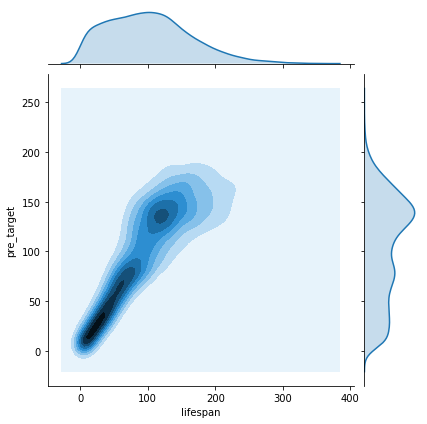

In [47]:
sns.jointplot(x="lifespan", y="pre_target", kind="kde", data=oof);

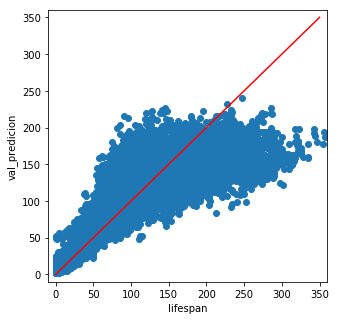

In [48]:
plt.figure(figsize=(5,5))
plt.plot(oof['lifespan'], oof['pre_target'], 'o')
plt.plot(np.array([0,350]), np.array([0,350]), c='red')
plt.xlabel('lifespan')
plt.ylabel('val_predicion')
plt.xlim([-10, 360])
plt.ylim([-10, 360]);

In [70]:
# submit
sub_df = pd.DataFrame({'EngineID': df_test['EngineID'],
                       'EngineIndex': df_test['EngineIndex'],
                       'pre_border': test_pre_border,
                       'pre_lifespan_under100': test_pre_under * target_under_max,
                       'pre_lifespan_over100': test_pre_over * target_over_max})

sub_df['Predicted RUL'] = sub_df['pre_lifespan_over100'] * (1 - sub_df['pre_border']) + sub_df['pre_lifespan_under100'] * sub_df['pre_border']
sub_df.to_csv('C0003_07_05_2019_pre.csv', index=False)

# 必要なのは各エンジンの最後の行のみ
sub_df = sub_df[sub_df['EngineID'].astype('category').cat.codes.diff(-1) != 0]
sub_df['Predicted RUL'].to_csv('C0003_07_05_2019.csv', index=False)

In [66]:
oof.to_csv('C0003_07_05_2019_oof.csv', index=False)

In [72]:
sub_df

,EngineID,EngineIndex,pre_border,pre_lifespan_under100,pre_lifespan_over100,Predicted RUL
57,Test_Engine_001,57,0.312675,87.618897,139.653326,123.383454
253,Test_Engine_002,195,0.988220,30.443045,121.097204,31.510975
378,Test_Engine_003,124,0.200450,87.296893,144.548390,133.072310
428,Test_Engine_004,49,0.040425,90.833110,172.321886,169.027735
591,Test_Engine_005,162,0.979256,6.161653,124.832794,8.623388
654,Test_Engine_006,62,0.395704,85.171224,136.619731,116.261355
825,Test_Engine_007,170,0.958761,5.836303,120.225824,10.553555
893,Test_Engine_008,67,0.037433,92.234076,146.519117,144.487082
979,Test_Engine_009,85,0.933256,60.897981,121.303229,64.929652
1128,Test_Engine_010,148,0.984590,33.892175,123.334834,35.270457
